In [1]:
%matplotlib inline


import pandas as pd
import numpy as np
import regex
import os, sys
import matplotlib.pyplot as plt

# USER INPUTS

In [2]:



"""Experiment name to prepend output files"""
# EXPERIMENT = "18014_graphing-2"
# EXPERIMENT = 'filtered-sample-nh'
EXPERIMENT = 'filtered-ratios'
# EXPERIMENT = '18014'

"""Directory path to input data 
    (filtered; output from '1-read_fastq_id_features)
"""
# FILTERED_FILEPATH = "../output/filtered-sample-nh.csv"
FILTERED_FILEPATH = "../output/filtered-ratios.csv"
# FILTERED_FILEPATH = "../output/filtered-18014.csv"
# FILTERED_FILEPATH = '../../../2016-09-19-validation_graphs_redoes/data/filtered-ratios.csv'
"""Directory path to save output"""
OUTPUT_DIRECTORY = "../output"

"""Minimum number of reads as a baseline. Used to simplify data processing."""
MIN_READS = 100


# PRESETS AND SCRIPT

In [3]:
"""
# NEED TO FIGURE HOW TO RELOAD DEPENDENT FUNCTIONS
UPON VALUE CHANGES
Column names correspoinding to eponymous variables"""

SAMPLE = 'idx'
QTAG = 'qtag'
BARCODE = 'barcode'
READS = 'readsPF'
MCOUNTS = 'mcountsPF'
PERCENT_MCOUNTS = 'percent_%s'%MCOUNTS
GROUPBY = ['idx']# for older versions/ formats

In [4]:
def check_inputs():
    
    # modules
    assert pd
    assert np
    assert regex
    assert os
    assert sys
    
    # user experiment inputs 
    assert EXPERIMENT
    assert FILTERED_FILEPATH
    assert OUTPUT_DIRECTORY
    assert MIN_READS
    
    # user columns
    assert SAMPLE
    assert QTAG
    assert BARCODE
    assert READS
    assert MCOUNTS
    assert PERCENT_MCOUNTS
    assert GROUPBY
    

In [5]:
# 2016-11-04 updated to include filter delete bool feature
"""calculate_percent_molecs
    calculates percent of mcounts of barcodes.
    df: pd.DataFrame() 
    mcounts: str, optional, col to calculate percents, default MCOUNTS
    percent_mcounts: str, col to assign values to, default PERCENT_MCOUNTS
    filters: list, np.array, dict, columns and bool values to filter values
    
    Returns: 
        df with updated percent_mcounts values
"""
def calculate_percent_molecs(df, mcounts=MCOUNTS, percent_mcounts=PERCENT_MCOUNTS, filters=[]):
    """Updates percent molec counters for sample"""
    
    df.loc[:,percent_mcounts] = 0.
    if len(filters) > 0:
        var, val = filters[0]
        cond = (df[var]==val)
        i = 1
        while i < len(filters):
            var, val = filters[i]
            cond = cond & (df[var]==val)
            i+=1
    else:
        cond = ()
    total = df.loc[cond, mcounts].values.sum() / 100.
    df.loc[cond,percent_mcounts] = df.apply(lambda x: x[mcounts]/total, axis=1)
    df.sort_values(by=[percent_mcounts,mcounts, BARCODE], 
                   ascending=[0,0,1], inplace=True)
    return df

In [6]:
def load_data(filtered_file, sample=SAMPLE, qtag=QTAG, 
              barcode=BARCODE, mcounts=MCOUNTS, reads=READS):
    """Loads filtered lib-ID-barcode data csv to dict of samples"""
    columns = [sample, qtag, barcode, mcounts, reads]
    # loads excel file (all tabs)
    
    csv = pd.read_csv(filtered_file)
    # filter out null barcodes just in case (if custom user input)
    csv = csv.loc[(csv[qtag]!='None') & (csv[barcode]!='None')]
    csv = csv[columns]
    csv[sample] = csv[sample].apply(lambda x: str(x))
    # get percent molecs per sample, store as output dict entry 
    groups = csv.groupby(sample)
    data = []
    for i, group in csv.groupby(sample):
        data.append((i,calculate_percent_molecs(group)))
    return data


In [7]:
def check_data(d, sample=SAMPLE, mcounts=MCOUNTS, reads=READS):
    """Check data for proper format, input values, and 
    converts into list-like object if necessary

    d(list, np.array ,dict, or pd.DataFrame): input data
    
    Returns: data set as a list-like object, wherein
        each item is a pair containing sample name (str) and 
        sample data (pd.DataFrame), in that order.
    """
    data_arr = []
    # wrangle data to list of list-like pairs, as "[idx, df]"
    if type(d) in [np.array, list] :
        data_arr = d
    elif type(d) == dict:
        data_arr = d.items()
    elif type(d) == pd.DataFrame :
        data_arr = [(s,df) for s,df in d.groupby(sample)]
    else:
        print "Input data is not in correct format. Please provide \
        list-like, dict, or pd.DataFrame object."
    
    # check input has correct values
    try:
        for a in data_arr:
            assert len(a) == 2, "incorrect item length"
            s, df = a
            assert type(s) == str, 'sample name is not string type'
            assert type(df) == pd.DataFrame, "incorrect value type: must be pd.DataFrame"
            assert sample in df.columns, "%s not in dataframe"%sample
            assert mcounts in df.columns, "%s not in dataframe"%mcounts
            assert reads in df.columns, "%s not in dataframe"%reads
    # if no 
    except IndexError as e:
        print "Item number of values is not 2.\n"
        print "IndexError. ",e.message
        print a
    except ValueError as e:
        print "Sample name could not be converted to float: %s\n"% type(item[i])
        print "ValueError. ",e.message
        print a
    except AssertionError as e:
        print "Assertion failed:"
        print e.message
        print a
    
    return data_arr

In [8]:
"""OLD THRESHOLD"""

def threshold(group, reps_remaining, thresh_mcounts,threshold_log,
             mcounts=MCOUNTS):
    """Thresholds barcodes of a given sample

        group(pd.DataFrame): df containing library-ID-barcodes, 
            mcountsPF and percent_mcountsPF
        reps_remaining(int): reps remaining from max number 
            input from user 
        thresh_val(float or int): initial threshold value (percent_mcountPF)
            provided from previous recursion or user input
        thresh_i(int): initial position of threshold value in 
            percent_mcountsPF list, ranging 0,len(group)

        Returns: 
            None, if thresholding fails;
            passed(pd.DataFrame), if thresholding successful; or
            self, otherwise, with updated threshold values and 
                group df.
    """
#     print "\nSTART", len(group)
    # max out reps
    if reps_remaining <= 0:
        print 'Maxed out reps. Skipping sample.'
    # no barcodes passed threshold 
    elif len(group[group[mcounts]>1]) == 0:
        print "No barcodes passed threshold. Skipping sample."
    else:
        # calculate new threshold 
        group.sort_values(by=mcounts, ascending=False, inplace=True)
        mcount_vals = group.loc[(group['passed']==True)|(group['is_padding']==True)][mcounts].values
#         mcount_vals = thresh_group[mcounts].values
#         mcount_vals = mcount_vals + [1] if thresh_mcounts < 0 or len(thresh_group) <= 3 else mcount_vals
#         print "G", group
#         print "THRG", thresh_group
#         print"MCV",  mcount_vals
#         print "else", reps_remaining, len(group), len(mcount_vals)
        new_thresh_mcounts = calculate_threshold(mcount_vals)
#         print "after", reps_remaining, len(group), thresh_mcounts, new_thresh_mcounts
        
        threshold_log.append(len(group.loc[group[mcounts]>=new_thresh_mcounts]))
#         print 'old',group.loc[(group[mcounts]>=thresh_mcounts)&(group[mcounts]>1)][['qtag','barcode','mcountsPF','passed','is_padding']]
#         print 'new',group.loc[group[mcounts]>=new_thresh_mcounts][['qtag','barcode','mcountsPF','passed','is_padding']]
#         print len(thresh_group.loc[thresh_group[mcounts]>new_thresh_mcounts])
        print len(group.loc[(group['passed']==False)]), len(group.loc[(group['passed']==True)]),new_thresh_mcounts
        print group[['idx','qtag','barcode','mcountsPF','passed','is_padding']][:10]
#         print len(group), len(thresh_group)
        # if reached steady state
        if new_thresh_mcounts == thresh_mcounts:
#             re_thresholded_v = calculate_threshold(group.loc[group['passed']==True][mcounts].values)
#             print thresh_mcounts, re_thresholded_v
#             passed = eliminate_oneoffs(group, re_thresholded_v, pad=False)
#             passed = eliminate_oneoffs(group, new_thresh_mcounts, pad=False)
#             print len(group.loc[group['passed']==True]), len(passed.loc[passed['passed']==True])
    
#             group.loc[:,'passed'] = group.apply(lambda x:
#                             True if (x['passed']==True) and
#                             (x['is_padding']==False) and
#                             (x[mcounts]>=new_thresh_mcounts) else False, axis=1)
            
#             passed_val = calculate_threshold(group.loc[group['passed']==True])
#             passed_val = group.loc[group['passed']==True,mcounts].min()
            group.loc[:,'passed'] = group.apply(lambda x: True if x['passed']==True and x[mcounts]>thresh_mcounts else False,
                                               axis=1)
            print group.loc[group['passed']==True][['idx','qtag','barcode','mcountsPF','passed','is_padding']]
#             print len(group.loc[group['passed']==True]), passed_val

#             threshold_log.append(len(group.loc[group[mcounts]>=passed_val]))
            print "\t\t\t", threshold_log
#             group.loc[(group['passed']==True)
#                               &(group['is_padding']==False)
#                               &(group[mcounts]>=thresh_mcounts)]
            
#             group = calculate_percent_molecs(group,filters=[['passed',True],['is_padding',False]])
#             passed = calculate_percent_molecs(group, 
#                         filters=[['passed',True],['is_padding',False]])
#             print len(group.loc[group['passed']==True]), new_thresh_mcounts

            group.reset_index(inplace=True,drop=True)
            print "FINAL", len(group.loc[group['passed']==True])
            sys.stdout.write('Thresholded.\n')
            return group, threshold_log
        # recursively clean and re-threshold
        else:
#             print reps_remaining
#             print len(group), thresh_mcounts, new_thresh_mcounts
            # clean up group by eliminating one-offs
            cleaned = eliminate_oneoffs(group,new_thresh_mcounts)
            cleaned.reset_index(inplace=True,drop=True)
#             print reps_remaining, len(cleaned.loc[cleaned['passed']==True])
            # recurse with cleaned df and new threshold values
            return threshold(cleaned, reps_remaining-1, new_thresh_mcounts, threshold_log,
                             mcounts=mcounts)
        
    # if thresholding failed, return None
    sys.stdout.write('Skipped.\n')
    return pd.DataFrame()

In [61]:
# STEP 2: CALCULATE THRESHOLD VALUE via. CONCAVITY


def calculate_threshold(y, by='passed', mcounts=MCOUNTS):
    """Calculates threshold of series with modified concavity approach

        y(np.array or list): list or list-like object of 
            values as floats or ints

        Returns index of inflection point in array, 
            i.e. threshold position.
    """
    def rolling_window(arr):
        """Constructs list of overlapping subarray ranges of size 2"""
        shape = arr.shape[:-1] + (arr.shape[-1]-1, 2)
        strides = arr.strides + (arr.strides[-1],)
        windows = np.lib.stride_tricks.as_strided(arr, 
                              shape=shape, strides=strides)
        return windows
    def first_d_gen(windows):
        """Generates first derivative of windows as relative difference"""
        for w in windows:
            # amended 2016-10-12: normalize by y midpoint instead of second point to 
            # better represent the count magnitude of segment
#             yield float(w[1]-w[0])/(w[0]+w[1])
            yield float((w[1]-w[0]))/(w[1])
#             yield float((w[1]-w[0]))
    def second_d_gen(windows):
        """Generates second derivative of windows"""
        for w in windows:
            yield (w[1]-w[0])
            
    if type(y) in [np.ndarray, list]:
        x_temp = np.array([])
        y_temp = np.array(y)
    else:
        y = pd.DataFrame(y)
        sortby, cond = [mcounts], (y[mcounts]>0)
        if by in y.columns:
            sortby, cond = ['passed']+sortby, cond&(y['passed']==True) 
        passed = y.loc[cond].sort_values(by=sortby,ascending=False)[mcounts]
        x_temp = passed.index.values
        y_temp = passed.values
    
    
    y_temp = np.sort(np.array(y_temp))[::-1]
    # left and right padding to cover all array vals in derivations
#     suffix = [1]
#     suffix = [] if len(y_temp) > 2 else [1]
    suffix = [2]
#     suffix=[]
#     suffix = [] if len(y_temp) > 1 else [y_temp[0]]
#     suffix = [y_temp[len(y_temp)-1]/(y_temp[0]+y_temp[1])*2]
#     if len(y_temp) < 2:
#         suffix = [y_temp[len(y_temp)-1]/2]
#     else:
#         suffix =  [y_temp[len(y_temp)-1] -
#                    (y_temp[len(y_temp)-2]-y_temp[len(y_temp)-1])]
    y_temp = y_temp[y_temp>1]
    yarray = np.log10(np.concatenate([ [y_temp[0]], y_temp, suffix]))
    print yarray
#     print yarray
    # calculates first derivative
    first_windows = rolling_window(yarray)
    first_derivs = np.fromiter(first_d_gen(first_windows), np.float
                               , count=len(first_windows))
    print first_derivs
    # calculates second derivative
    
    second_windows = rolling_window(first_derivs[abs(first_derivs)<float('inf')])

    second_derivs = np.fromiter(second_d_gen(second_windows), np.float
                                , count=len(second_windows))
#     print rolling_window(second_derivs)
    # gets index or position value of inflection point (curves down ), adjust by adding 1
    # for second deriv
    second_idxs = np.where(abs(second_derivs)<float('inf'))
    second_derivs = second_derivs[second_idxs]
    print second_idxs
    print np.argmin(second_derivs)
    print len(second_idxs)
#     thresh_deriv_i2 = np.argmin(second_derivs)
#     thresh_deriv_i1 = 
#     thresh_i = min(second_idxs[thresh_deriv_i], 
#                    len(yarray)-1)
    thresh_deriv_i = second_idxs[0][np.argmin(second_derivs)] + 1
    
#     thres
    thresh_i = min(thresh_deriv_i, len(yarray)-1)
    thresh_v = 10**yarray[thresh_i]
    print second_derivs
    print first_derivs[thresh_i]
    print thresh_i, yarray[thresh_i]
#     print "min", np.min(second_derivs), np.argmin(second_derivs)
#     print 'max', np.max(second_derivs), np.argmax(second_derivs)
    return thresh_v

In [11]:
def eliminate_oneoffs(g, thresh_val, pad=True,
                      qtag=QTAG, barcode=BARCODE, passed='passed',
                      barcode_error = 'barcode_error',
                      qtag_error = 'qtag_error',
                      mcounts=MCOUNTS):
    """Eliminate barcodes that are one position off from a more-abundant barcode
        group(pd.DataFrame): df containing qtag, barcode, and percent_mcounts columns
        thresh_val(float): threshold value to select high abundant barcodes
            to iterate through as 'major' ones
        pad(bool): if True, adds a right pad so last non-eliminated value 
            can be analyzed in by the threshold() function. Default True.
        qtag, barcode, percent_mcounts, mcounts (str): column names for the corresponding
            argument. Defaults are global vars QTAG, BARCODE, PERCENT_MCOUNTS, MCOUNTS.

        Returns: table of barcodes that passed elimination
        
        For regex package info, see https://pypi.python.org/pypi/regex/
    """
    g.sort_values(by=mcounts, ascending=False, inplace=True)
#     g.loc[g[mcounts] < thresh_val, 'passed'] = False
    g.loc[:,'is_padding'] = False
#     print "elim", len(g), thresh_val, len(g.loc[g['passed']==True]), len( g.loc[(g['passed']==True)&(g[mcounts])>=thresh_val])
#     majors = filter_g.loc[(filter_g[mcounts])>thresh_val]
    i = 0
    # add capability to check other parameters, i.e. qtag
#     for maj_i, maj_r in g.loc[(g['passed']==True)&(g[mcounts])>=thresh_val].iterrows():
    for maj_i, maj_r in g.loc[(g['passed']==True)].iterrows():
        # if it has not yet been tested
        if g.loc[maj_i,'passed'] == True:
#             print 'passed maj', maj_r[mcounts]
#             minors = filter_g.loc[filter_g[mcounts]<maj_r[mcounts]]

            minors = g.loc[(g['passed']==True)&(g[mcounts]<maj_r[mcounts])]

            # for each 'minor' barcode aka. with fewer molecs, test if one-off from major
            for min_i, min_r in minors.iterrows():
                query = regex.search("(%s){s<=1}"% maj_r[barcode], min_r[barcode])
                if query:
                    g.loc[min_i,'passed'] = False
                    g.loc[min_i,'barcode_error'] += 1 if sum(query.fuzzy_counts)>0 else 0
                    g.loc[min_i,'qtag_error'] += 1 if min_r[qtag]!=maj_r[qtag] else 0
                                          
            i+=1
                    
#     # if requested, adds a right pad  
#     # line added 2016-10-12: combine two conditions: ensure that 
#     # no null rows get added if all barcodes are accepted
#     print "THR VAL",thresh_val
#     print g['passed']==False

    if pad==True and len(g) != len(g.loc[g['passed']==False]):
        min_true_val = g.loc[(g['passed']==True),mcounts].values.min
        pad_i_choices = [ g.loc[(g['passed']==False)&(g[mcounts]<tval),mcounts][:2].index.values 
                         for tval in [min_true_val,thresh_val] ]
        pad_i = pad_i_choices[np.argmin([len(c) for c in pad_i_choices])]
        print pad_i_choices
        print pad_i, np.argmin([len(c) for c in pad_i_choices])
#         pad_min_true = g.loc[(g['passed']==False)&(g[mcounts]<min_true_val),mcounts][:2].index.values
#         pad_i_thresh = g.loc[(g['passed']==False)&(g[mcounts]<thresh_val),mcounts][:2].index.values
        
#         pad_i = g.loc[(g['passed']==False)&(g[mcounts]<thresh_val),mcounts][:2].index.values
        print "PADI", pad_i
        for pi in pad_i:
            g.loc[pi,'is_padding'] = True
    return g
            

In [17]:
def run_threshold(d, sample=SAMPLE, qtag=QTAG, barcode=BARCODE, 
                  mcounts=MCOUNTS, reads=READS, percent_mcounts=PERCENT_MCOUNTS,
                  min_reads=MIN_READS, min_mcount=50):
    """Run threshold algorithm for each sample in dataset

        d(np.array, list, dict, or pd.DataFrame): dataset for all samples
        sample, qtag, barcode, mcounts, reads, percent_mcounts(str): columns in df for 
            corresponding vals. Defaults are global vars SAMPLE, QTAG, BARCODE, MCOUNTS, 
            READS, PERCENT_MCOUNTS.
        min_reads(int): minimum number of reads for a library-ID-barcode as an 
            absolute baseline (that which any barcode below is highly likely to be 
            false.) Default is global var MIN_READS.
        min_mcount(int): minimum number of molecs for library-ID-barcode as an
            absolute baseline. Default is 50.

        Note: min_reads and min_mcount are applied to increase performance.

        Returns: 
            pd.DataFrame, if successful, of 'true' (passed) library-ID-barcodes 
                for all samples
            None, if no samples had passing library-ID-barcodes.
    """
    passed = []
    all_threshold_logs = {}
    counter = 1
    # checks and formats data (d) to list-like obj of pairs
    data_arr = check_data(d, sample=sample, mcounts=mcounts, reads=reads)
    # run for each (sample, df) in dataset 
    for s, group in data_arr:
        sys.stdout.write("\n-------------\nSample %d of %d (%s): "%(counter,len(data_arr),s))
        # select valid data meeting absolute baseline 
        g = group.loc[(group[qtag] != 'None') & (group[barcode] != 'None') ]
#                           & (group[mcounts] > min_mcount)
#                           & (group[reads] > min_reads)]
        if len(g.loc[g[mcounts]>2])>0:
            g.loc[:,'passed'] = True
            g.loc[:,'qtag_error'] = False
            g.loc[:,'barcode_error'] = False
            g.loc[:,'is_padding'] = False
            result, tlogs = threshold(g, 20, -1, [])
            passed.append(result)
            all_threshold_logs[s] = tlogs
        sys.stdout.flush()
        counter += 1


    # if we do have data (i.e. some barcodes that passed in the samples)
    if len(passed) > 0:
        # concat all df together
        passeddf = pd.concat(passed)
        passeddf.sort_values(by=[sample,percent_mcounts]
                             ,ascending=[True, False]
                             ,inplace=True)
        passeddf.reset_index(inplace=True,drop=True)
        return passeddf, all_threshold_logs
    else:
        print "No samples were successfully thresholded."
    return 

### SCRIPT TO SAVE DATA TO CSVs

In [13]:
def save_data(filtered,passed, output_directory=OUTPUT_DIRECTORY, experiment=EXPERIMENT):
    
    # Save passed dataframe
    passed.to_csv('%s/threshold-%s-passed.csv'%(output_directory,experiment), index=False)
    # count and save results
    counts = count_sample_barcodes(passed)
    counts.to_csv('%s/threshold-%s-counts.csv'%(output_directory,experiment), index=False)
    # merge passed and filtered data and save
    fc_temp = pd.concat([d[1] for d in filtered])
    filtered_concat = apply_passed_data(fc_temp, passed)
    filtered_concat.to_csv('%s/threshold-%s-merged.csv'%(output_directory,experiment), index=False)

In [14]:
def count_sample_barcodes(df, groupby=SAMPLE, barcode=BARCODE, sample=SAMPLE, qtag=QTAG
                      , percent_mcounts=PERCENT_MCOUNTS):
    """Counts passed barcodes per sample and saves as csv
    
        df(pd.DataFrame): input dataframe containing passed 
            barcodes of all samples
        groupby(str or list-like): columns to group samples by
    """
    agg = df.groupby(groupby).agg(len)
    counts = agg[agg.columns[0]]
    counts.name = 'count'
    counts = pd.DataFrame(counts)
    counts.reset_index(inplace=True)
    return counts



In [15]:
def apply_passed_data(filtered, passeddf, sample=SAMPLE, qtag=QTAG
                      , barcode=BARCODE, percent_mcounts=PERCENT_MCOUNTS):
    """Cross reference passed barcodes with raw filtered data
        filtered(pd.DataFrame): raw filtered data as dataframe for all samples
        passed(pd.DataFrame): data passed threshold (output of run_threshold)
        sample,qtag,barcode,percent_mcounts(str): names corresponding to df columns.
            Defaults are SAMPLE,QTAG,BARCODE,PERCENT_MCOUNTS.

        Returns:
            filtered(pd.DataFrame) updated with 'passed_threshold' and 
            percent_mcounts columns
    """
    def cross_ref_passed(row):
        key = (row[sample],row[qtag],row[barcode])
        if key in passed_indexed.index:
            row.loc[:,percent_mcounts+'_thresholded'] = passed_indexed.loc[key,percent_mcounts]
            row.loc[:,'passed_threshold'] = True
        return row

    passed_indexed = passeddf.set_index([sample,qtag,barcode])
    filtered.rename(columns={percent_mcounts:percent_mcounts+'_filtered'})
    filtered.loc[:,'passed_threshold'] = False
    filtered.loc[:,percent_mcounts+'_thresholded'] = 0
    filtered = filtered.apply(cross_ref_passed, axis=1)
    return filtered



# EXECUTE SCRIPT BELOW

In [62]:
if __name__=='__main__':
    # Check all inputs exist and are valid
    check_inputs()
    # Runs data loading in script
    filtered = load_data(FILTERED_FILEPATH)
    # Run thresholding of all samples in dataset
    passeddf, all_threshold_logs = run_threshold(filtered)
#     save_data(filtered, passeddf, output_directory=OUTPUT_DIRECTORY, experiment=EXPERIMENT)

C:\Users\vwl698\Anaconda2\lib\site-packages\ipykernel\__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-------------
Sample 1 of 27 (1): [ 4.90101126  4.90101126  2.42488164  2.18184359  1.74036269  1.71600334
  1.53147892  1.462398    1.34242268  1.2787536   1.07918125  0.95424251
  0.90308999  0.77815125  0.77815125  0.77815125  0.77815125  0.77815125
  0.60205999  0.60205999  0.60205999  0.47712125  0.30103     0.30103   ]
[ 0.         -1.02113422 -0.11139114 -0.25367178 -0.0141954  -0.12048774
 -0.04723811 -0.08937224 -0.04978995 -0.18492941 -0.13092975 -0.05664167
 -0.16055842  0.          0.          0.          0.         -0.29248125
  0.          0.         -0.26185951 -0.5849625   0.        ]
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21], dtype=int64),)
0
1
[-1.02113422  0.90974308 -0.14228064  0.23947638 -0.10629234  0.07324962
 -0.04213413  0.03958228 -0.13513946  0.05399966  0.07428809 -0.10391675
  0.16055842  0.          0.          0.         -0.29248125  0.29248125
  0.         -0.26185951 -0.32310299  0.5849625 ]

In [92]:
fconcat = pd.concat([d[1] for d in filtered if d[0][:2]!="VL" ])
merged = fconcat.merge(passeddf, 
              on=['idx','qtag','barcode','mcountsPF','readsPF'], 
                       how='outer')
merged.drop(['percent_mcountsPF_x','is_padding'],axis=1, inplace=True)
merged.rename(columns={'percent_mcountsPF_y':"percent_mcountsPF"}, inplace=True)
merged = merged.fillna(value={'passed':False,'qtag_error':False,'barcode_error':False,
                    'percent_mcountsPF':0.})

In [22]:
passeddf.loc[passeddf['passed']==True].groupby('idx').apply(len)
passeddf.to_csv("%s/thresholded-%s.csv"%(OUTPUT_DIRECTORY,EXPERIMENT), index=False)

In [98]:
lib_name = 'ratios'
# custom to fix error
# passeddf['newidx'] = passeddf.idx.apply(lambda x: "%s-%s%s"%(lib_name, "0" if len(x)<7 else "", x.split('18014')[-1]))
passeddf['newidx'] = passeddf.idx.apply(lambda x: "%s-%s%s"%(
        lib_name, "0" if len(x.split("-")[-1])<2 else "", x.split('-')[-1]))
passeddf.idx = passeddf.newidx
passeddf.drop("newidx",axis=1,inplace=True)

In [63]:
passeddf.loc[passeddf['passed']==True].groupby('idx').apply(len)


idx
1     1
10    3
11    2
12    2
13    2
14    3
15    3
16    4
17    4
18    5
19    6
2     1
20    5
21    5
22    5
23    5
24    5
25    6
26    4
3     1
4     1
5     1
7     2
8     2
9     2
dtype: int64

In [36]:
passeddf.loc[(passeddf['passed']==True)]
#              |(passeddf.mcountsPF>500)]

idx qtag  barcode  mcountsPF  readsPF  percent_mcountsPF passed  \
263   14  q19  GGGCGGC      21111    22459                0.0   True   
264   14  q27  CGCATAG      16209    16977                0.0   True   
353   15  q25  GGAGCCA      17705    18607                0.0   True   
354   15  q27  GAGGAGT      10116    10409                0.0   True   
538   17  q19  CTGGCGT       5933     6028                0.0   True   
539   17  q24  GCTTTAG       5218     5305                0.0   True   
540   17  q26  CGTAAAC       2852     2879                0.0   True   
541   17  q27  GCGGTAG       2653     2678                0.0   True   
607   18  q19  GGGCGGC      14184    14750                0.0   True   
608   18  q24  CAGAAGT      11074    11405                0.0   True   
754   19  q19  CCGCCTG       7671     7840                0.0   True   
755   19  q26  CGCTTTG       6449     6564                0.0   True   
756   19  q24  CCAGTTG       5745     5832                0.0   True   
757   19  q27  GAGGAGT       5450     5544                0.0   True   
758   19  q25  ACAATGA       3677     3721                0.0   True   
759   19  q24  ATTCGCT       1833     1843                0.0   True   
916    2  q24  CAGAAGT      75662    95471                0.0   True   
947   20  q24  GCTTTAG       3079     3107                0.0   True   
948   20  q19  CTGGCGT       2885     2906                0.0   True   
949   20  q25  CCCGTCT       2518     2547                0.0   True   
950   20  q26  CGTAAAC       1578     1587                0.0   True   
951   20  q27  GCGGTAG       1072     1075                0.0   True   
1014  21  q26  CATATAT      17785    18720                0.0   True   
1015  21  q19  GGGCGGC       7552     7705                0.0   True   
1016  21  q25  GGAGCCA       5876     5967                0.0   True   
1017  21  q24  CAGAAGT       5546     5625                0.0   True   
1407  24  q19  GGGCGGC      12299    12736                0.0   True   
1408  24  q27  CGCATAG      11083    11455                0.0   True   
1409  24  q26  CATATAT       7881     8031                0.0   True   
1410  24  q24  CAGAAGT       7192     7347                0.0   True   
1549  25  q26  CGCTTTG      19390    20515                0.0   True   
1550  25  q27  GAGGAGT      14273    14838                0.0   True   
1551  25  q19  CCGCCTG       9789    10048                0.0   True   
1552  25  q24  CCAGTTG       4173     4222                0.0   True   
1553  25  q25  ACAATGA       3404     3448                0.0   True   
1725  26  q26  CGTAAAC      19019    20018                0.0   True   
1827   3  q24  GCTTTAG         40       40                0.0   True   
1865   5  q27  CGCATAG      71214    88842                0.0   True   
1903   7  q19  GGGCGGC      43283    49084                0.0   True   
1979   8  q25  GGAGCCA      36053    40086                0.0   True   

     qtag_error barcode_error is_padding  
263       False         False      False  
264       False         False      False  
353       False         False      False  
354       False         False      False  
538       False         False      False  
539       False         False      False  
540       False         False      False  
541       False         False      False  
607       False         False      False  
608       False         False      False  
754       False         False      False  
755       False         False      False  
756       False         False      False  
757       False         False      False  
758       False         False      False  
759       False         False      False  
916       False         False      False  
947       False         False      False  
948       False         False      False  
949       False         False      False  
950       False         False      False  
951       False         False      False  
1014      False         False      False  
1015      False     

In [54]:
shortdf = passeddf.loc[passeddf['passed']==True].copy()
shortdf.drop(["passed",'qtag_error','barcode_error','is_padding'], axis=1, inplace=True)
shortdf = shortdf.loc[shortdf.mcountsPF>100]
shortdf.reset_index(inplace=True,drop=True)
shortdf['idx'] = shortdf.idx.astype(int)

In [55]:
# manual wrangling to remove false positives
def apply_calculate_percent_molecs(g):
    total = g.mcountsPF.values.sum()/100.
    g[PERCENT_MCOUNTS] = g.mcountsPF.apply(lambda x: x/total)
    return g
shortdf = shortdf.groupby('idx').apply(apply_calculate_percent_molecs)
shortdf.sort_values(by=['idx','percent_mcountsPF'],ascending=[1,0],inplace=True)


In [56]:
shortdf

idx qtag  barcode  mcountsPF  readsPF  percent_mcountsPF
0     1  q19  GGGCGGC      79618   102145         100.000000
35    2  q24  CAGAAGT      75662    95471         100.000000
71    4  q24  GCTTTAG      89143   118591         100.000000
72    5  q27  CGCATAG      71214    88842         100.000000
73    7  q19  GGGCGGC      43283    49084          56.549517
74    7  q24  CAGAAGT      33257    36561          43.450483
75    8  q25  GGAGCCA      36053    40086          57.929494
76    8  q26  CGCTTTG      26183    28094          42.070506
77    9  q27  GAGGAGT      49738    57584          71.686148
78    9  q19  CCGCCTG      19645    20767          28.313852
1    10  q24  CCAGTTG      41816    47259          62.244716
2    10  q24  ATTCGCT      15702    16376          23.373028
3    10  q25  ACAATGA       9662     9910          14.382257
4    11  q26  CGTAAAC      81232   104913          91.154127
5    11  q27  GCGGTAG       7883     8044           8.845873
6    12  q19  CTGGCGT      78535   100514          95.486765
7    12  q24  GCTTTAG       3712     3739           4.513235
8    13  q25  CCCGTCT      69129    85469          99.711520
9    13  q26  CATATAT        200      201           0.288480
10   14  q19  GGGCGGC      21111    22459          40.854201
11   14  q27  CGCATAG      16209    16977          31.367806
12   14  q24  CAGAAGT      14354    14904          27.777993
13   15  q25  GGAGCCA      17705    18607          47.230966
14   15  q27  GAGGAGT      10116    10409          26.986075
15   15  q26  CGCTTTG       9665     9944          25.782959
16   16  q19  CCGCCTG      35493    39366          72.942313
17   16  q25  ACAATGA       6945     7090          14.272796
18   16  q24  CCAGTTG       4664     4713           9.585072
19   16  q24  ATTCGCT       1557     1566           3.199819
20   17  q19  CTGGCGT       5933     6028          35.620797
..  ...  ...      ...        ...      ...                ...
41   21  q26  CATATAT      17785    18720          42.211568
42   21  q19  GGGCGGC       7552     7705          17.924192
43   21  q25  GGAGCCA       5876     5967          13.946313
44   21  q24  CAGAAGT       5546     5625          13.163079
45   21  q27  CGCATAG       5374     5472          12.754848
46   22  q26  CGCTTTG      40450    45571          70.988575
47   22  q25  ACAATGA       4369     4421           7.667468
48   22  q27  GAGGAGT       4094     4139           7.184851
49   22  q19  CCGCCTG       3575     3611           6.274021
50   22  q24  CCAGTTG       3413     3456           5.989716
51   22  q24  ATTCGCT       1080     1081           1.895369
52   23  q27  GCGGTAG      37849    42369          78.630934
53   23  q19  CTGGCGT       3774     3831           7.840449
54   23  q25  CCCGTCT       2643     2662           5.490807
55   23  q24  GCTTTAG       2635     2656           5.474187
56   23  q26  CGTAAAC       1234     1238           2.563623
57   24  q19  GGGCGGC      12299    12736          27.973253
58   24  q27  CGCATAG      11083    11455          25.207542
59   24  q26  CATATAT       7881     8031          17.924807
60   24  q24  CAGAAGT       7192     7347          16.357723
61   24  q25  GGAGCCA       5512     5603          12.536675
62   25  q26  CGCTTTG      19390    20515          37.998001
63   25  q27  GAGGAGT      14273    14838          27.970370
64   25  q19  CCGCCTG       9789    10048          19.183210
65   25  q24  CCAGTTG       4173     4222           8.177703
66   25  q25  ACAATGA       3404     3448           6.670717
67   26  q26  CGTAAAC      19019    20018          48.767917
68   26  q19  CTGGCGT       9703     9960          24.880125
69   26  q27  GCGGTAG       6717     6849          17.223519
70   26  q24  GCTTTAG       3560     3596           9.128439

[79 rows x 6 columns]

In [33]:
shortdf.to_csv('%s/passed-%s.csv'%(OUTPUT_DIRECTORY, EXPERIMENT), index=False)

## GRAPHING

In [60]:
itypes = {
    (True,False,False):'passed', #passed
    (False,True,False):'qtag mismatch', #qtag error
    (False,False,True):'barcode oneoff', #barcode error
    (False,False,False):'other error', #not one-off
    (False,True,True):'other error'
}

for itype in itypes:
    keys = ['passed','qtag_error','barcode_error']
    ca = [(merged[k]==v) for k,v in zip(keys,itype)]
    cond = ca[0]&ca[1]&ca[2]
    merged.loc[(cond),'itype'] = itypes[itype]
    
ctypes = {
    'passed':'#11BF08',
    'barcode oneoff': '#DE092B',
    'qtag mismatch':'#EBA709',
    'other error':'#2A52D5'
}
itype_order = [
    'passed',
    'other error',
    'barcode oneoff',
    'qtag mismatch'
]

1 1 2
1 2 1
10 1 2
11 1 2
12 1 2
13 1 2
14 1 4
14 2 2
15 1 4
15 2 2
16 1 39
16 3 2
17 1 42
17 3 13
18 1 147
19 1 79
2 1 2
2 2 1
20 1 6
20 3 4
21 1 6
21 2 2
22 1 67
22 3 2
23 1 42
23 3 2
24 1 6
24 2 3
25 1 103
26 1 102
4 1 2
4 2 1
5 1 2
5 2 1
7 1 3
7 2 2
8 1 3
8 2 2
9 1 2


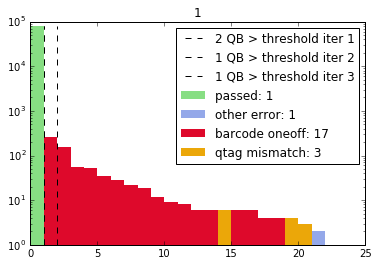

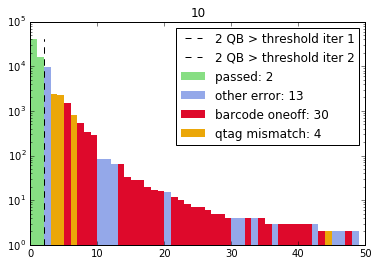

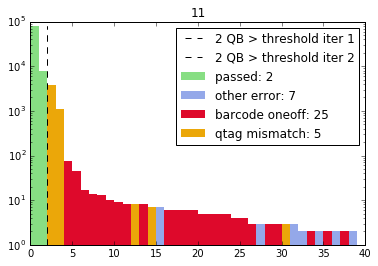

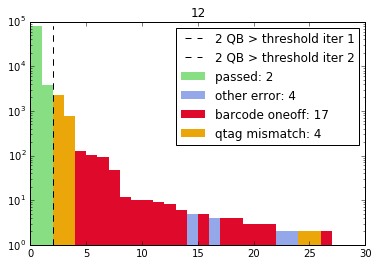

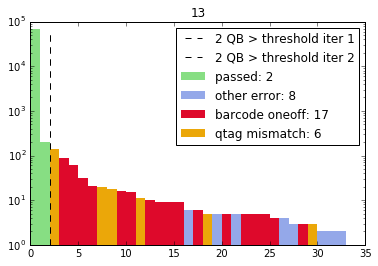

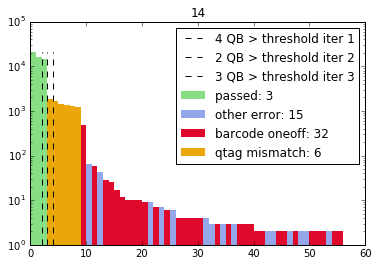

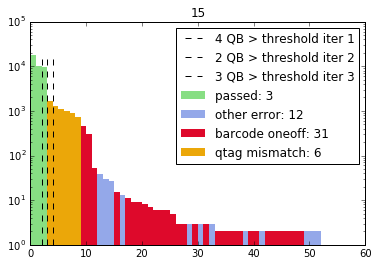

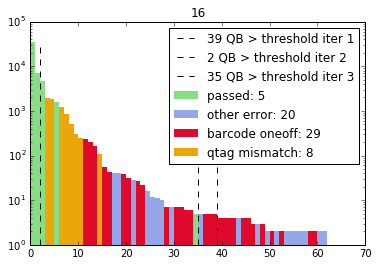

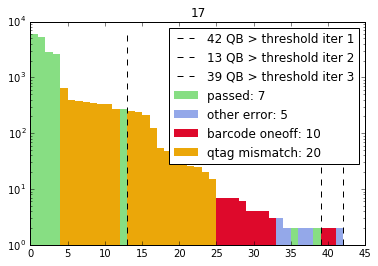

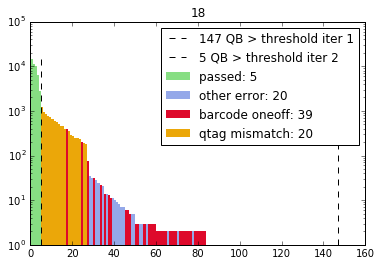

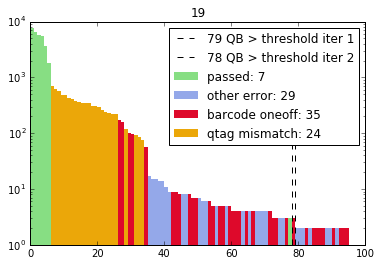

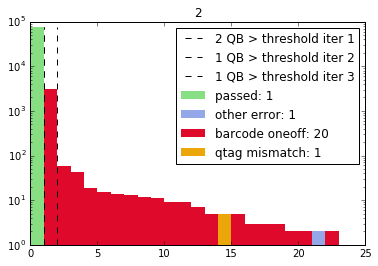

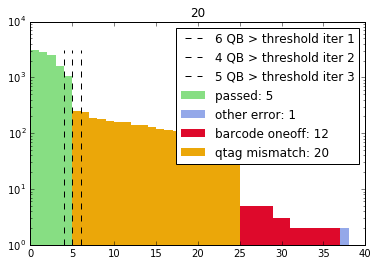

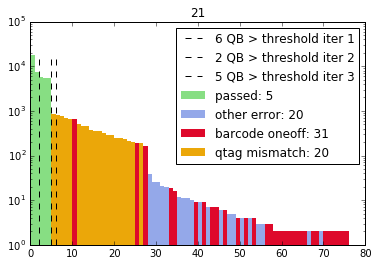

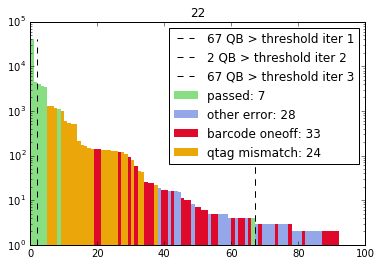

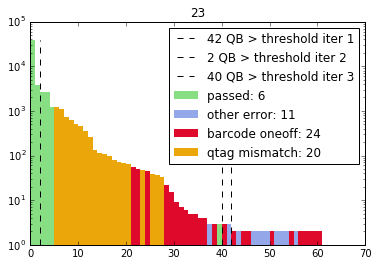

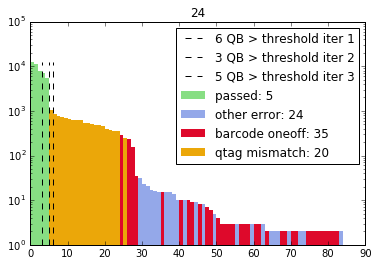

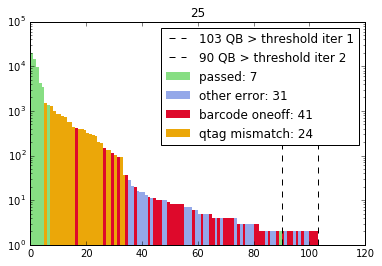

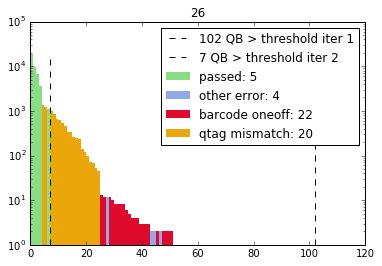

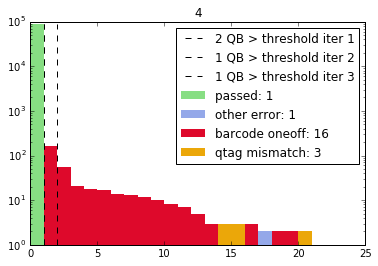

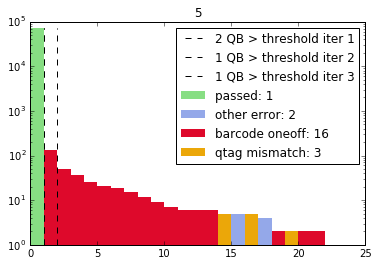

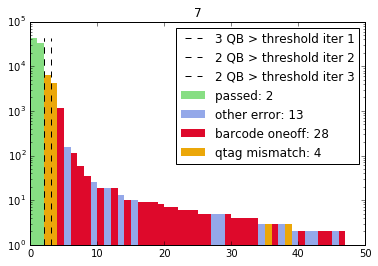

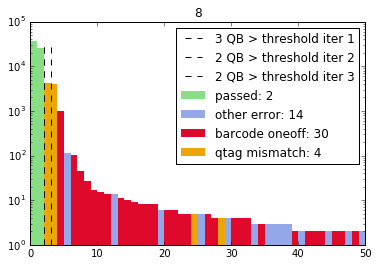

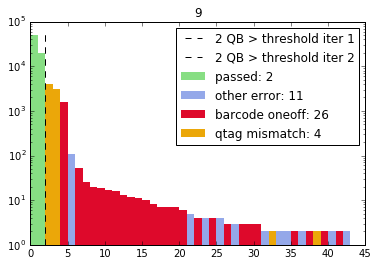

In [63]:
# plots scatter
plottype = 'bar'
mcounts=MCOUNTS
counter = 0
for idx, group in merged.groupby('idx'):
#     if idx[:2]=='NH':
    if group[mcounts].sum()>1000:
        gslice = group.sort_values(by=mcounts,ascending=False)
        gslice = gslice.loc[gslice[mcounts]>1]
        counts = gslice[mcounts].values
        itypes = gslice.itype.values
        it_present= np.unique(itypes)
        
        f, ax = plt.subplots(1)
        for itype in itype_order:
            if itype in it_present:
                x = np.where(itypes==itype)[0]
                y = counts[x]
                label = "%s: %d"%(itype,len(x))
                color = ctypes[itype]
                alpha = 0.5 if itype in ['passed','other error'] else 1
                edgecolor=color
                lw = 1.5
                s = 250 if itype in ['barcode oneoff','qtag mismatch'] else 8
                marker = "|" if itype in ['barcode oneoff','qtag mismatch'] else "-o-"
                    
                if plottype == 'scatter':
                    ax.scatter(x+1, y, color=color, edgecolors=edgecolor,
                            alpha=alpha, label=label, 
                            marker=marker, lw=lw, s=s)
                    
                else:
                    ax.bar(x, y, color=color, alpha=alpha, 
                           label=label, lw=0, width=1 )
        
        thresh_values = all_threshold_logs[idx]
        thresh_line_fmts = [1, 0.5]
        last_round = 1
        last_val = 0
        for tline in range(1,len(thresh_values)):
            
            thresh_line = thresh_values[tline] 
            if thresh_line != last_val:
                print idx,tline, thresh_line
    #             thresh_line =np.max(np.where(itypes=='passed')[0])+1
    #             alpha = thresh_line_fmts[len(thresh_values)-tline-1]
                alpha = 1
                ax.plot([thresh_line,thresh_line],[1,max(counts)], 
                        color = 'black', alpha = 1, ls = '--',
                        label='%d QB > threshold iter %d'%(thresh_line, last_round))
                last_val = thresh_line
                last_round += 1
        thresh_line =np.max(np.where(itypes=='passed')[0])+1
        ax.plot([thresh_line,thresh_line],[1,max(counts)], 
                color = 'black', alpha = 1, ls = '--',
                label='%d QB > threshold iter %d'%(thresh_line, last_round))
        
        ax.set_yscale('log')
        ax.set_xlim(0)
        ax.legend()
        ax.set_title(idx)
        f.savefig('../output/%s_%s.png'%(EXPERIMENT, idx))
#         break


    